# Severity of illness

In [281]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
%matplotlib inline
plt.style.use('ggplot') 



# Hard-coded colors
COLORS = np.asarray(
    [[55,126,184],
    [228,26,28],
    [77,175,74],
    [152,78,163],
    [255,127,0],
    [255,255,51],
    [166,86,40],
    [247,129,191]])/256.0
MARKERS = ['+','o','s','^']

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [5]:

# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

In [6]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [116]:
# exclusion criteria:
#   - less than 16 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)

query = 'SET search_path to ' + schema_name + """;
with t1 as
(
select ie.icustay_id
    , ie.los
    , ROW_NUMBER() over (partition by ie.subject_id order by intime) as rn
    , adm.has_chartevents_data
from icustays ie
inner join admissions adm
  on ie.hadm_id = adm.hadm_id
inner join patients pat
    on ie.subject_id = pat.subject_id
    and pat.dob < ie.intime - interval '16' year
)
select icustay_id
from t1
where rn = 1
and has_chartevents_data = 1
and los >= (4/24)
"""

cohort = pd.read_sql_query(query,con)
cohort.head().T

,0,1,2,3,4
icustay_id,211552,294638,228232,220597,229441


In [119]:

query = query_schema + \
"""
select 
    ie.icustay_id
    , adm.hospital_expire_flag
    , sa.saps
    , sa2.sapsii, sa2.sapsii_prob
    , aps.apsiii, aps.apsiii_prob
    , oa.oasis, oa.oasis_prob
from icustays ie
inner join admissions adm
  on ie.hadm_id = adm.hadm_id
inner join patients pt
  on ie.subject_id = pt.subject_id
left join saps sa
  on ie.icustay_id = sa.icustay_id
left join sapsii sa2
  on ie.icustay_id = sa2.icustay_id
left join oasis oa
  on ie.icustay_id = oa.icustay_id
left join apsiii aps
  on ie.icustay_id = aps.icustay_id
-- only include adult patients
where (ie.intime - pt.dob) > interval '1' year
"""
df = pd.read_sql_query(query,con)

df = cohort.merge(df, how='inner', left_on='icustay_id', right_on='icustay_id')
df.head()

,icustay_id,hospital_expire_flag,saps,sapsii,sapsii_prob,apsiii,apsiii_prob,oasis,oasis_prob
0,211552,0,34,79,0.918976,80,0.341819,57,0.748927
1,294638,0,10,35,0.166523,29,0.044555,26,0.054187
2,228232,0,18,24,0.058153,45,0.090356,11,0.008392
3,220597,1,18,31,0.116839,29,0.044555,35,0.152892
4,229441,0,6,25,0.064649,34,0.055769,29,0.077479


In [ ]:
# plot to illustrate severity scores
# e.g. distributions of scores
import sklearn.neighbors

def hist_and_kde(x, nbins):
    hist_output, bin_edges = np.histogram(x, nbins, density=True)
    bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])[:, np.newaxis]
    
    #plt.step(bin_center,histo,where='mid')
    #plt.show()
    kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=1).fit(x[:, np.newaxis])
    kde_output = np.exp(kde.score_samples(bin_center))
    
    # reshape to 1 axis
    bin_center = bin_center.ravel()
    return bin_center, hist_output, kde_output

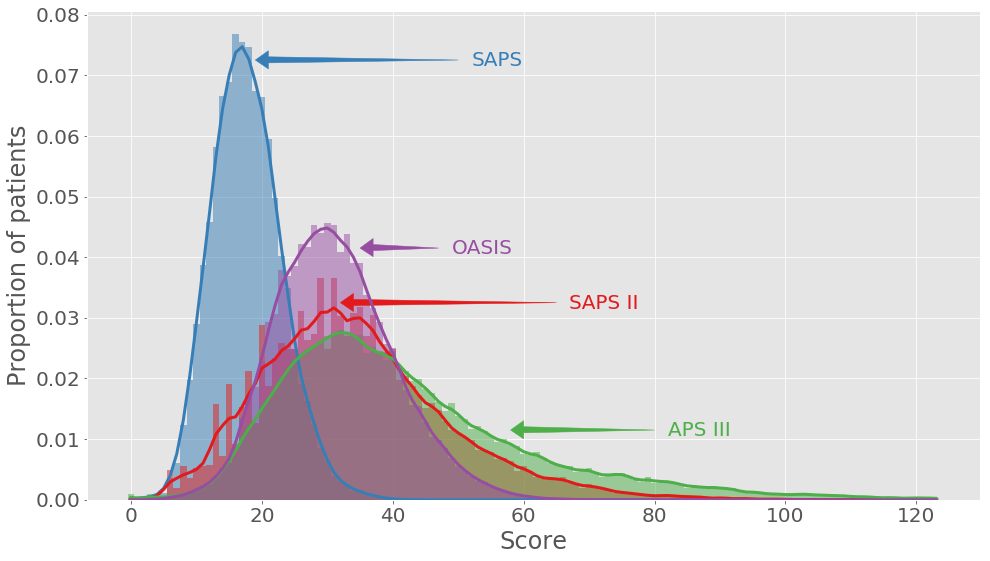

In [272]:
scores = ['saps','sapsii','apsiii','oasis']
scoresPretty = ['SAPS', 'SAPS II', 'APS III', 'OASIS']
nbins = np.asarray(range(125))-0.5

plt.figure(figsize=[16,9])
for i, s in enumerate(scores):
    bin_center, hist_output, kde_output = hist_and_kde(df[s].values, nbins)

    plt.bar(bin_center, hist_output, width=1.0, fc=COLORS[i], alpha=0.5, label=scoresPretty[i])
    plt.plot(bin_center, kde_output, color=COLORS[i], lw=3)
plt.xlabel('Score')
plt.ylabel('Proportion of patients')

arrowLocs = { 'saps': [50, 0.073, -31, -0.0005],
            'sapsii': [65, 0.033, -33, -0.0005],
            'apsiii': [80, 0.012, -22, -0.0005],
            'oasis': [47, 0.042, -12, -0.0005] }

textLocs = { 'saps': [arrowLocs['saps'][0]+2, arrowLocs['saps'][1]-0.0015],
           'sapsii': [arrowLocs['sapsii'][0]+2, arrowLocs['sapsii'][1]-0.0015],
           'apsiii': [arrowLocs['apsiii'][0]+2, arrowLocs['apsiii'][1]-0.0015],
            'oasis': [arrowLocs['oasis'][0]+2, arrowLocs['oasis'][1]-0.0015]}

head_length = {'saps': 2, 'oasis': 2, 'sapsii': 2, 'apsiii': 2}
width = {'saps': 0.001, 'oasis': 0.001, 'sapsii': 0.001, 'apsiii': 0.001}
# add text/arrows
for i, s in enumerate(scores):
    textLoc = textLocs[s]
    arrowLoc = arrowLocs[s]
    plt.arrow(arrowLoc[0], arrowLoc[1], arrowLoc[2], arrowLoc[3],
              length_includes_head=True,
              head_length=head_length[s], width=width[s], fc=COLORS[i], ec=COLORS[i])
    plt.text(textLoc[0], textLoc[1], scoresPretty[i], color=COLORS[i] )

#plt.legend(loc='upper right')
plt.savefig('SeverityOfIllnessDistribution.png')
plt.show()

In [209]:
scoresPretty

['SAPS', 'SAPS II', 'APS III', 'OASIS']

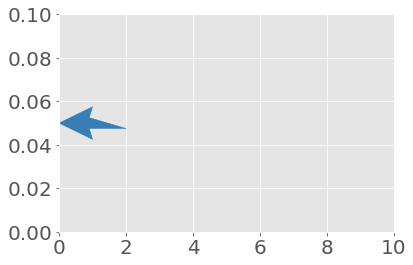

In [194]:
## # manually add text and arrows
textLoc = [45, 0.07]
arrowLoc = [2, 0.05, -2, 0]

plt.figure()
plt.arrow(arrowLoc[0], arrowLoc[1], arrowLoc[2], arrowLoc[3],
          length_includes_head=True, overhang=0.1,
          head_length=1, width=0.005, fc=COLORS[0], ec=COLORS[0])

plt.xlim([0,10])
plt.ylim([0,0.1])
plt.show()

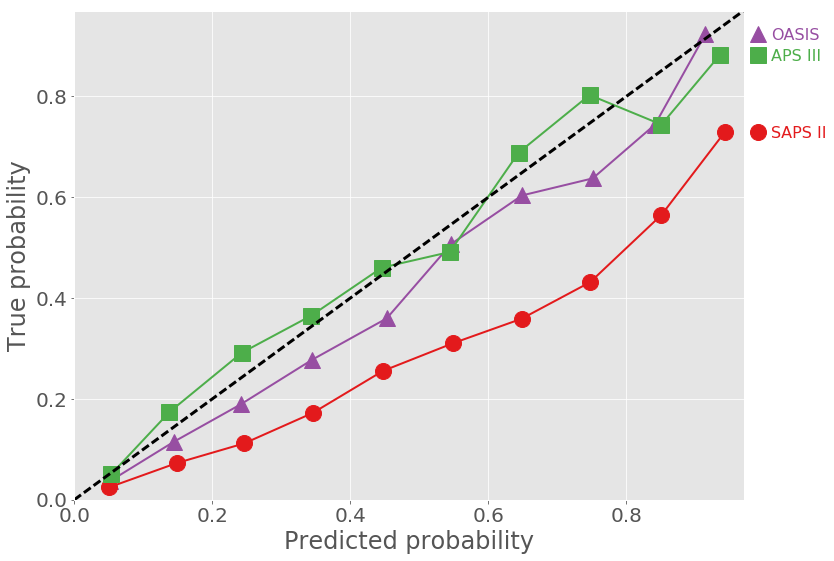

In [286]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=[12,9])

sevscores = ['oasis_prob','sapsii_prob','apsiii_prob']
sevscores_pretty = {'sofa': 'SOFA',
                    'sofa_oracle': 'SOFA (old)',
                    'oasis': 'OASIS',
                    'oasis_prob': 'OASIS',
                    'saps': 'SAPS',
                    'sapsii': 'SAPS II',
                    'sapsii_prob': 'SAPS II',
                    'apsiii': 'APS III',
                    'apsiii_prob': 'APS III'}
sevscores_num = {'saps': 0,
                'sapsii': 1,
                'sapsii_prob': 1,
                'apsiii': 2,
                'apsiii_prob': 2,
                'oasis': 3,
                'oasis_prob': 3}

for s, sevscore in enumerate(sevscores):    
    # calculate the calibration curve
    mean_true, mean_pred = \
            calibration_curve(df['hospital_expire_flag'], df[sevscore], n_bins=10)
    # use the dictionary to map the severity score to a consistent color/linestyle/marker
    i = sevscores_num[sevscore]
    plt.plot(mean_pred, mean_true, label=sevscores_pretty[sevscore],
             color=COLORS[i], marker=MARKERS[i],
             linewidth=2, linestyle='-', markersize=16)
    
    # Add a text label to the right end of every line
    y_pos = mean_true[-1]
    # plot marker
    plt.plot(0.99, y_pos, color=COLORS[i], marker=MARKERS[i], linewidth=2, linestyle=None, markersize=16, clip_on=False)
    plt.text(1.01, y_pos-0.012, sevscores_pretty[sevscore], fontsize=16, color=COLORS[i])    

plt.plot([0,0.97],[0,0.97],color='black',linestyle='--',linewidth=3)

# set plot limits
plt.xlim([0,0.97])
plt.ylim([0,0.97])

# pretty the plot
plt.ylabel('True probability')
plt.xlabel('Predicted probability')
plt.grid('on')

plt.savefig('SeverityScoresCalibCurve.png')
plt.show()